Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
winner_idx:  0
Test_acc:  0.9124
Train_acc:  0.9811111111111112
Predicted:  frog ( 0.9999995231628418 )


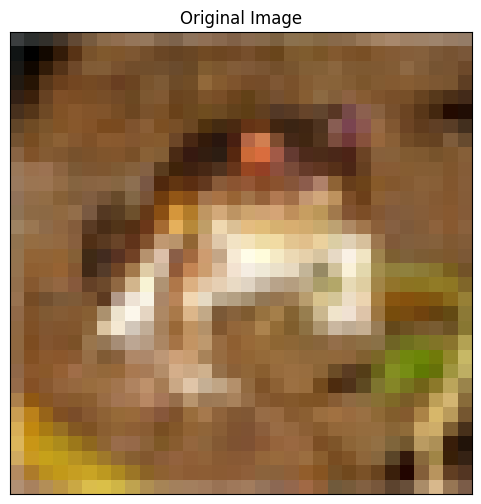

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


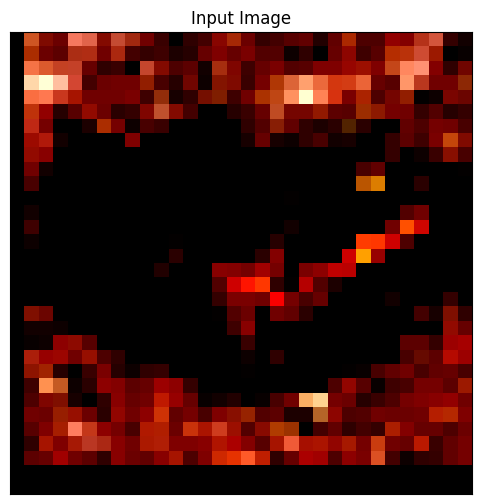

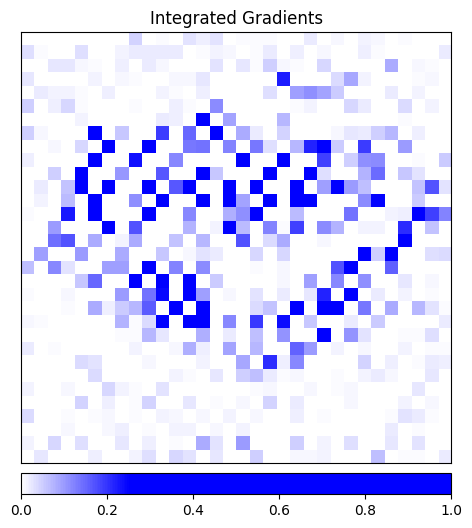

In [11]:
import pickle
import torch
import time
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
import numpy as np
import torchvision
import torchvision.transforms as transforms
from resnet20 import Resnet_N_W
from Hparams import Hparams
from utils_Earlystopper import EarlyStopper
import utils
import routines

import captum
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as F


try:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except NameError or ModuleNotFoundError:
    pass

#setting the path to store/load dataset cifar10
workdir = Path.cwd()
data_path = workdir / "datasets" / "cifar10_2"
if not data_path.exists():
    data_path.mkdir(parents=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random_state = 0 #TODO: see notes on phone

with utils.TorchRandomSeed(random_state):
#data augmentation
    mean = [0.4914, 0.4822, 0.4465]
    std = [0.2023, 0.1994, 0.2010]
    transform = transforms.Compose(
        [transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
        ])
    
    transform_nothing = transforms.Compose(
        [
        transforms.ToTensor()
        ])


    dataset_hparams = Hparams.DatasetHparams()
    #(down)load dataset cifar10
    dataloaderhelper = utils.DataLoaderHelper(
        split_seed=0,
        data_order_seed=0,
        val_seed=0,
        test_seed=0,
        datasethparams=dataset_hparams
        )
    trainset = dataloaderhelper.get_trainset(data_path, transform)
    testset = dataloaderhelper.get_testset(data_path, transform)
    trainset_orig = dataloaderhelper.get_trainset(data_path, transform_nothing)
    testset_orig = dataloaderhelper.get_testset(data_path, transform_nothing)
    trainset, valset = dataloaderhelper.split_train_val(trainset)
    trainloader = dataloaderhelper.get_train_loader(trainset)
    testloader = dataloaderhelper.get_test_loader(testset)
    valloader = dataloaderhelper.get_validation_loader(valset)

#get test image
test_img_orig, label = trainset_orig[0]
test_img, label = trainset[0]
test_img = test_img.unsqueeze(0) #dummy batch dimension
test_img = test_img.cuda() if torch.cuda.is_available() else test_img

models, all_model_stats, _1, _2, _3, _4 = routines.load_experiment("e2_7")

winner = routines.find_winning_ticket(models, all_model_stats)
winner.eval()
print("Test_acc: ", routines.get_accuracy(device, winner, testloader))
print("Train_acc: ",routines.get_accuracy(device, winner, trainloader))

#calculate output
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
output = winner(test_img)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = classes[int(pred_label_idx.item())]
print('Predicted: ', predicted_label, '(', prediction_score.squeeze().item(), ')')

#Integrated gradients
integrated_gradients = IntegratedGradients(winner)
attributions_ig = integrated_gradients.attribute(test_img, target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(test_img_orig.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image")

# Show the input image for comparison
_ = viz.visualize_image_attr(None, np.transpose(test_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Input Image")


default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(test_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')